In [1]:
# Image stitching

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Loading images

img1 = cv2.imread("stitching/1.jpg")
img2 = cv2.imread("stitching/2.jpg")

In [3]:
def show_image(opencv_image):
    b, g, r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r, g, b])
    plt.imshow(rgb_image)
    plt.show()

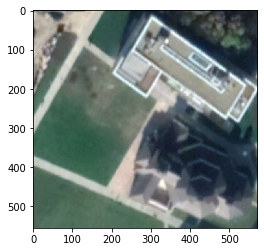

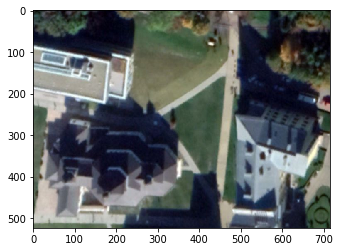

In [4]:
show_image(img1)
show_image(img2)

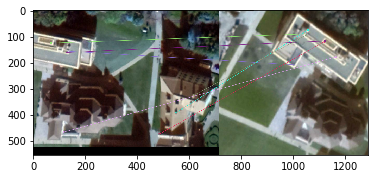

In [5]:
# finding ORB descriptors

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
 
# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 8 matches
img3 = cv2.drawMatches(img2, kp2, img1, kp1, matches[:8], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

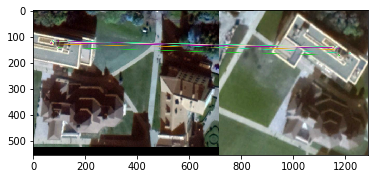

In [6]:
## finding BRISK descriptors

# Initiate BRISK detector
brisk = cv2.BRISK_create()

# find the keypoints and descriptors with ORB
kp1, des1 = brisk.detectAndCompute(img1, None)
kp2, des2 = brisk.detectAndCompute(img2, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
 
# Match descriptors
matches = bf.match(des2, des1)

# Sort them in the order of their distance
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 8 matches
img3 = cv2.drawMatches(img2, kp2, img1, kp1, matches[:8], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [7]:
## finding homography matrix
match_num = 50
src = np.float64([kp1[m.trainIdx].pt for m in matches[:match_num]]).reshape(-1,1,2)
dst = np.float64([kp2[m.queryIdx].pt for m in matches[:match_num]]).reshape(-1,1,2)
H, _ = cv2.findHomography(dst, src, cv2.RANSAC, 5.0)
H

array([[ 1.08573923e+01, -1.07368187e+00,  3.76921182e+02],
       [ 4.09142919e+00,  2.35372552e+00, -2.50467227e+02],
       [ 1.76677000e-02,  4.26906313e-04,  1.00000000e+00]])

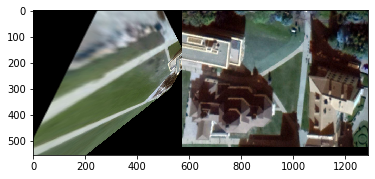

In [8]:
## stitch two images
dst = cv2.warpPerspective(img1, H, (img2.shape[1] + img1.shape[1], img1.shape[0]))
dst[0:img2.shape[0], img1.shape[1]:img2.shape[1] + img1.shape[1]] = img2
plt.imshow(dst)
plt.show()

In [9]:
# Convolutional neural networks

In [10]:
# loading data
import numpy as np
from keras.utils import np_utils

train_images = np.load("recognition/data/images_train.npy")
train_labels = np.load("recognition/data/labels_train.npy")
test_images = np.load("recognition/data/images_test.npy")
test_labels = np.load("recognition/data/labels_test.npy")
# helicopter is 0, bird is 1

Using TensorFlow backend.
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kwh44/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [11]:
train_images.shape, test_images.shape

((2000, 32, 32, 3), (1000, 32, 32, 3))

In [12]:
train_labels.shape, test_labels.shape

((2000,), (1000,))

In [13]:
train_labels = np_utils.to_categorical(train_labels, 2)
test_labels = np_utils.to_categorical(test_labels, 2)
train_labels.shape, test_labels.shape

((2000, 2), (1000, 2))

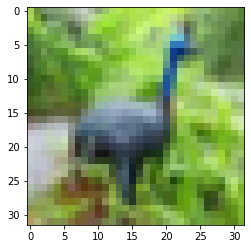

(<matplotlib.image.AxesImage at 0x7ff1f7782d30>,
 None,
 array([0., 1.], dtype=float32))

In [14]:
plt.imshow(train_images[0]), plt.show(), train_labels[0]

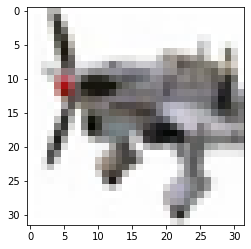

(<matplotlib.image.AxesImage at 0x7ff1f7769908>,
 None,
 array([1., 0.], dtype=float32))

In [15]:
plt.imshow(train_images[11]), plt.show(), train_labels[11]

In [25]:
# building LeNet5

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import AveragePooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
# training LeNet5
model.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
2000/2000 [==============================] - 1s 512us/step - loss: 4.3951 - accuracy: 0.6265
Epoch 2/10
2000/2000 [==============================] - 1s 354us/step - loss: 1.9048 - accuracy: 0.7400
Epoch 3/10
2000/2000 [==============================] - 1s 393us/step - loss: 0.7288 - accuracy: 0.7710
Epoch 4/10
2000/2000 [==============================] - 1s 375us/step - loss: 0.4521 - accuracy: 0.8120
Epoch 5/10
2000/2000 [==============================] - 1s 377us/step - loss: 0.3440 - accuracy: 0.85750s - loss: 0.3451 - accuracy: 0.85
Epoch 6/10
2000/2000 [==============================] - 1s 397us/step - loss: 0.2758 - accuracy: 0.8930
Epoch 7/10
2000/2000 [==============================] - 1s 364us/step - loss: 0.2249 - accuracy: 0.9100
Epoch 8/10
2000/2000 [==============================] - 1s 348us/step - loss: 0.1876 - accuracy: 0.9255
Epoch 9/10
2000/2000 [==============================] - 1s 383us/step - loss: 0.1617 - accuracy: 0.9390
Epoch 10/10
2000/2000 [=======

In [27]:
(loss, accuracy) = model.evaluate(test_images, test_labels, batch_size=100, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

1000/1000 [==============================] - 0s 287us/step
[INFO] accuracy: 82.10%


In [29]:
# improving LeNet5

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam

input_shape = (32, 32, 3)
model = Sequential()


model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(AveragePooling2D())
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [30]:
# training LeNet5
model.fit(train_images, train_labels, batch_size=100, epochs=20, verbose=1)

Epoch 1/20
2000/2000 [==============================] - 1s 553us/step - loss: 4.1436 - accuracy: 0.5845
Epoch 2/20
2000/2000 [==============================] - 1s 381us/step - loss: 0.9368 - accuracy: 0.6655
Epoch 3/20
2000/2000 [==============================] - 1s 415us/step - loss: 0.5671 - accuracy: 0.7205
Epoch 4/20
2000/2000 [==============================] - 1s 360us/step - loss: 0.4702 - accuracy: 0.7920
Epoch 5/20
2000/2000 [==============================] - 1s 407us/step - loss: 0.4125 - accuracy: 0.8230
Epoch 6/20
2000/2000 [==============================] - 1s 412us/step - loss: 0.3762 - accuracy: 0.8450
Epoch 7/20
2000/2000 [==============================] - 1s 385us/step - loss: 0.3332 - accuracy: 0.8580
Epoch 8/20
2000/2000 [==============================] - 1s 399us/step - loss: 0.3025 - accuracy: 0.8720
Epoch 9/20
2000/2000 [==============================] - 1s 363us/step - loss: 0.2840 - accuracy: 0.8855
Epoch 10/20
2000/2000 [==============================] - 1s 401u

In [31]:
(loss, accuracy) = model.evaluate(test_images, test_labels, batch_size=100, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

1000/1000 [==============================] - 0s 327us/step
[INFO] accuracy: 83.50%
